In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
from datasets import load_dataset
import plotting

: 

In [2]:
import pandas as pd
import subprocess
import en_core_web_sm
import numpy as np
import dask.dataframe as dd

from lexical_diversity import lex_div as ld
import itertools
import matplotlib.pyplot as plt  

from scipy.stats import spearmanr, kendalltau


from dask.distributed import Client
client = Client(n_workers=100, threads_per_worker=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 100
Total threads: 400,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41675,Workers: 100
Dashboard: http://127.0.0.1:8787/status,Total threads: 400
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:46019,Total threads: 4
Dashboard: http://127.0.0.1:42767/status,Memory: 10.08 GiB
Nanny: tcp://127.0.0.1:34603,


## Perplexity Ngram 

In [3]:
from transformers import RobertaTokenizerFast


from nltk.lm import MLE
from datasets import load_dataset
import pandas as pd

from nltk.util import everygrams


def get_order_increasing_difficulty_perplexity_ngram(dataset_name="loris3/stratified_10m_curriculum", n_gram=1, train_subsample_factor = 1):
    """
    Returns a training data order by increasing difficulty estimated with an ngram MLE model
    code from https://github.com/codebyzeb/CLIMB/blob/dc4f13c1bdf94938d468f0926368dee048485cba/src/data_curriculum/difficulty_scorer/perplexity.py#L77
    adapted to accept hf datasets
    """
    out_path = os.path.join("./difficulty_ngram",str(n_gram), os.path.basename(dataset_name))
    print(out_path)
    if os.path.isdir(out_path):
        print("Skipping {}, already calculated".format(out_path) )
    else:
        tokenizer = RobertaTokenizerFast.from_pretrained(dataset_name+"_random", max_len=512)

        dataset = load_dataset(dataset_name)["train"]
        dataset.set_transform(lambda x : tokenizer(x["text"], return_special_tokens_mask=True, truncation=True, max_length=512))
        train_data_n_grams = [
            list(everygrams(sent, max_len=n_gram))
            for sent in  
            (
                [str(id) for id in input_ids if id != tokenizer.pad_token_id]  # type: ignore
                    for input_ids in dataset[0 : dataset.num_rows : train_subsample_factor]["input_ids"]
            )
        ]
        train_vocab = [str(val) for val in tokenizer.vocab.values()]

        print("Fitting {}-gram model".format(n_gram))
        lm = MLE(n_gram)
        lm.fit(train_data_n_grams, train_vocab)
        print("Getting perplexity with {}-gram model".format(n_gram))
        df = pd.DataFrame([lm.perplexity(example) for example in train_data_n_grams])
        df.columns=["perplexity"]
        df.index.name = "document_id"
        os.makedirs(out_path)
        df.to_parquet(os.path.join(out_path,"perplexity"))

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


### Mean Document Lenght

In [4]:

def get_difficulty_metrics(dataset_name, df):
    out_path = os.path.join("./difficulty_metrics", os.path.basename(dataset_name))
    if not os.path.exists(out_path):
        
        
        nlp = en_core_web_sm.load()

        def mean_sentence_length(doc):
            l = [sum((1 for word in sentence if word.is_alpha)) for sentence in nlp(doc).sents]
            if len(l) > 0:
                return np.mean(l)
        def ttr(doc):
            l = [token.text.lower() for token in nlp(doc) if token.is_alpha]
            if len(l) > 0:
                return ld.ttr(l)
        def log_ttr(doc):
            l = [token.text.lower() for token in nlp(doc) if token.is_alpha]
            if len(l) > 0:
                return ld.log_ttr(l)
        def mattr(doc):
            l = [token.text.lower() for token in nlp(doc) if token.is_alpha]
            if len(l) > 0:
                return ld.mattr(l,window_length=5)
        # def ttr(doc):
        #     w = [token for token in doc if token.is_alpha]
            
            
        ddf = dd.from_pandas(df[["text"]], npartitions=100)


        ddf['mean_sentence_length'] = ddf["text"].map_partitions(
        lambda series: series.apply(mean_sentence_length),  meta=('mean_sentence_length', 'float64')
        )
        ddf['ttr'] = ddf["text"].map_partitions(
        lambda series: series.apply(ttr),  meta=('ttr', 'float64')
        )
        ddf['log_ttr'] = ddf["text"].map_partitions(
        lambda series: series.apply(log_ttr),  meta=('log_ttr', 'float64')
        )
        ddf['mattr'] = ddf["text"].map_partitions(
        lambda series: series.apply(mattr),  meta=('mattr', 'float64')
        )
        os.makedirs(out_path)
        df = ddf.compute()
        df.index.name = "document_id"
        df.to_parquet(os.path.join(out_path,"mean_sentence_length"))
    return pd.read_parquet(os.path.join("./difficulty_metrics", os.path.basename(dataset_name)))


In [5]:
def get_corr(curriculum_name="random.pt", dataset_name = "loris3/stratified_equitoken_10m_curriculum", dataset_split = "train", model_name = "loris3/stratified_equitoken_10m_curriculum_random"):

    df, _ = plotting.load_data_for_plotting(dataset_name, dataset_split, curriculum_name)


    script_path = "compute_difficulty.py"
    arguments = [model_name, dataset_name]
    command = ["python", script_path] + arguments
    result = subprocess.run(command, capture_output=True, text=True, check=True)


    get_order_increasing_difficulty_perplexity_ngram(dataset_name=dataset_name)
    get_order_increasing_difficulty_perplexity_ngram(dataset_name=dataset_name, n_gram=2)
    get_order_increasing_difficulty_perplexity_ngram(dataset_name=dataset_name, n_gram=3)


    df_perplexity = pd.read_parquet(os.path.join("./difficulty", os.path.basename(dataset_name), os.path.basename(model_name)))
    df_perplexity_unigram = pd.read_parquet(os.path.join("./difficulty_ngram", "1", os.path.basename(dataset_name)))
    df_perplexity_bigram = pd.read_parquet(os.path.join("./difficulty_ngram", "2", os.path.basename(dataset_name)))
    df_perplexity_trigram = pd.read_parquet(os.path.join("./difficulty_ngram", "3", os.path.basename(dataset_name)))

    df_metrics = get_difficulty_metrics(dataset_name, df)

    order_increasing_difficulty_perplexity = lambda d: d.reindex(df.index)["perplexity"].sort_values(ascending=True).index
    def vals():
        for (a, a_name), (b, b_name) in itertools.product(
            [
                (order_increasing_difficulty_perplexity(df_perplexity), "model_perplexity"),
                (df["total"].sort_values(ascending=False).index, "model_tracin_influence"),
                (df_metrics["mean_sentence_length"].sort_values(ascending=True).index, "mean_sentence_length"),
                (df_metrics["ttr"].sort_values(ascending=True).index, "ttr"),
                (df_metrics["log_ttr"].sort_values(ascending=True).index, "log_ttr"),
                (df_metrics["mattr"].sort_values(ascending=True).index, "mattr"),
                (order_increasing_difficulty_perplexity(df_perplexity_unigram), "unigram_perplexity"),
                (order_increasing_difficulty_perplexity(df_perplexity_bigram), "bigram_perplexity"),
                (order_increasing_difficulty_perplexity(df_perplexity_trigram), "trigram_perplexity"),
                (df["stage"].str.extract(r'C(\d*):')[0].sort_values(ascending=True).index,"source_difficulty")
            ], repeat=2
        ):
            yield ( a_name, b_name, kendalltau(a, b, nan_policy="omit")[0])
            
        
    return pd.DataFrame(list(vals())).pivot(index=0, columns=1, values=2)


influence_output_dir ./mean_influence/stratified_equitoken_10m_curriculum_random/stratified_equitoken_10m_curriculum_train_stratified_equitoken_10m_curriculum_train
./difficulty_ngram/1/stratified_equitoken_10m_curriculum
Skipping ./difficulty_ngram/1/stratified_equitoken_10m_curriculum, already calculated
./difficulty_ngram/2/stratified_equitoken_10m_curriculum
Skipping ./difficulty_ngram/2/stratified_equitoken_10m_curriculum, already calculated
./difficulty_ngram/3/stratified_equitoken_10m_curriculum
Skipping ./difficulty_ngram/3/stratified_equitoken_10m_curriculum, already calculated


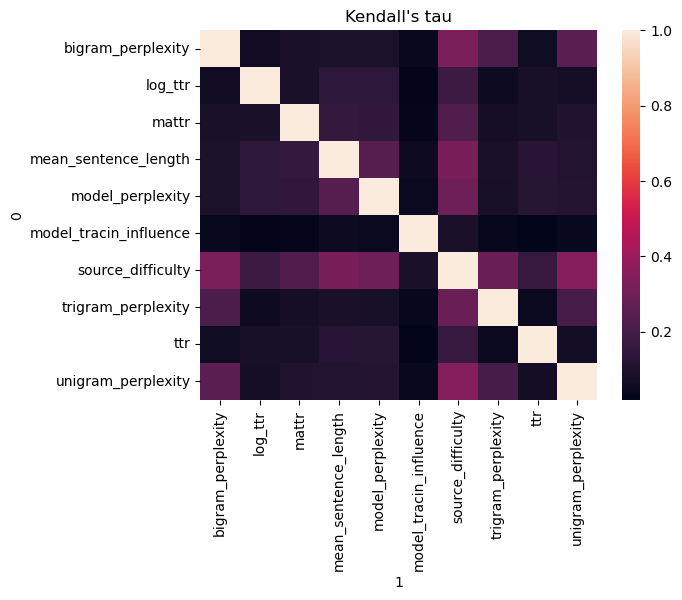

In [ ]:
import seaborn as sns


for task in [
    ("random.pt", 
      "loris3/stratified_equitoken_10m_curriculum", 
     "train", 
      "loris3/stratified_equitoken_10m_curriculum_random"
    ),
    ("random.pt", 
      "loris3/stratified_equitoken_10m_curriculum", 
     "train", 
      "loris3/stratified_equitoken_10m_curriculum_random"
    )
]:
    sns.heatmap(get_corr(*task))
    plt.title("Kendall's tau")
    plt.show()